# Extract informations from tax notice

# Document cropping 

In this project, we are going to implement two techniques to extract and crop a document from an image. 

- The first technique is a SIFT model (scale-invariant feature transform), a model used to identify similar elements between different images.


- The second is a model based on Kmeans for clusturing to segment the image into many blocs/objects, and openCV packages to detect the countour's document and rotate it based on its letter orientation.

We are going to start by SIFT Model :

# 1 - SIFT (scale-invariant feature transform) technique

SIFT or scale-invariant feature transform is a feature detection algorthim used in computer vision.

It helps locate local features of an image known as "keypoints". They're scale and rotation invariant that can be used for various computer vision applications, like image matching, object detection ...

To locate them, we have two main steps : 
    
- Constructing a Scale Space : To make sure that features are scale-independent 
- Keypoint Localisation: Identifying the suitable features or keypoints

Bellow an example of Eiffel Tower images captured from different angles, and also have different objects in the foreground.


<img src="images/tour_eifel.png" style="margin:auto"/>

### 1- 1. Constructing a Scale Space :  

We need to identify distinct features from any image regardless of noise. In addition, we need to ensure that those points are not scale-dependent.

For that, we use Gaussian Blurring technique, which reduce the noise of an image.  It computes for every pixel a value based on its neighboring pixels's values.

Here an examlpe of an image before and after apply the Gaussian Blurring technique : 

<img src="images/blur.JPG" style="margin:auto"/>

As we see, we reduced the image noise and highlighted its important features. Now, we need the ensure that these points aren't scale-dependent. This means, we'll search for these features on many scales by creating a scale-space, which is a collection of images of different scales generated from a single one.

To create this collection, we use the original image and reduce its scale by half then apply a Gaussian Blurring technique. Bellow an examle : 


<img src="images/collection.JPG" style="margin:auto"/>

The optimum number of times we need to scale the image and apply the Gaussian blur is 5/5. Means, at each time, we reduce the scale of the image by half then apply blurring five times.

<img src="images/octave.JPG" style="margin:auto"/>

So far we have created the scale-space. The second step is to use what we call Difference of Gaussian technique or DoG which is used in extracting independent features. DoG creates a new set of images, for each octave, by substracting one blurred version of an original image from another, less blurred version of the original.

Here how DoF works : 

<img src="images/DoG.JPG" style="margin:auto"/>

We created the DoF of a set of images with the same scale. Take a look at the below diagram. On the left, we have 5 images, all from the first octave (thus having the same scale). Each subsequent image is created by applying the Gaussian blur over the previous image.

<img src="images/octave_DoF.JPG" style="margin:auto"/>

We have enhanced features for each of these images. Note that we implemented it only for the first octave but the same process happens for all the octaves.

### 1- 2. Keypoint Localization

Once the images have been created, the next step is to find the important keypoints from the image that can be used for feature matching. The idea is to find the local maxima and minima for the images. This part is divided into two steps:



- Find the local maxima and minima
- Remove low contrast keypoints (keypoint selection)


For each image in the octave, every pixel is compared to its neighboring pixels. when we say neighboring, we mean the surrounding pixels of that image and the nine pixels of the previous and next image in the octave.

<img src="images/neighboring.png" style="margin:auto"/>

This means that the pixel x in the above diagram, is compared to 26 neighboring pixels to find whether it's a minima/maxima. It will be selected as a keypoint if it's the lower or the highest among its neighbors.

So far we have selected the potential keypoints, we ll do a last check to ensure that they're really scale-invariant and can represent the image. 

To deal with the low contrast keypoints, a second-order Taylor expansion is computed for each one. If the resulting value is less than 0.03 (in magnitude), we reject the keypoint.
Second, we perform a check to identify the poorly located keypoints. These are the keypoints that are close to the edge and have a high edge response but may not be robust to a small amount of noise. A second-order Hessian matrix is used to identify such keypoints. 

## 2 - Orientation Assignment :

At this stage, we have a set of keypoints of the image. Now, we ll assign an orientatiton to each of these keypoints so that they are invariant to rotation. we first compute the magnitude and orientation of each keypoint and create a histogram.


Let's consider the sample image below  : 

<img src="images/matrix.png" style="margin:auto"/>

Let's say we want to compute the magnitude and the rotation of the pixel in red. For this, we compute the gradient in x and y directions.  This comes out to be Gx = 9 and Gy = 14 respectively.
        

Once we have computed gradient, we can find the magnitude and the orientation using the following formulas : 
    

$$
\left\{\begin{array}{l}
Magnitude = \sqrt((Gx)^{2}+(Gy)^{2}) = 16.64\\
Φ = atan(Gy / Gx) = atan(1.55) = 57.17
\end{array}\right.
$$

Now, we can create our histogram : 
- On the x-axis, we ll have angles for angle values, like 0-9, 10 – 19, 20-29, up to 360. in our case, the rotation angle is 57.17, it will fall in the 6th bin. and the 6th bin value will be in proportion to magnitude value. We will do this for all the keypoint neighbors:

<img src="images/bin.JPG" style="margin:auto"/>

This histogram would peak at some point. The bin at which we see the peak will be the orientation for the keypoint. Additionally, if there is another significant peak (seen between 80 – 100%), then another keypoint is generated with the magnitude and scale the same as the keypoint used to generate the histogram. And the angle or orientation will be equal to the new bin that has the peak.

Finally, we get the set of the stable keypoints as shown in the figure below :

<img src="images/keypoint.JPG" style="margin:auto; width: 300px;"/>

We do the same for any Eifel tower image and we can match them easily as shown in the figure below : 

<table><tr>
<td> <img src="images/eiffel_tower.JPG" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/fleche_1.png" alt="Drawing" style="width: 100px;"/> </td>    
    
<td> <img src="images/sift_2.JPG" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## 3 - Implementation : 

In [ ]:
#######################################################################################
############################### Import packages########################################
#######################################################################################

from PIL import Image
from pdf2image import convert_from_path, convert_from_bytes
import pytesseract
import os
import pandas as pd
import numpy
import boxdetect

try:
    from PIL import Image
except ImportError:
    import Image
import pytesseract
import numpy as np
import re
import cv2
from difflib import SequenceMatcher
from matplotlib import pyplot as plt

import utils
from sklearn.cluster import KMeans

# If you don't have tesseract executable in your PATH, include the following:
# pytesseract.pytesseract.tesseract_cmd = 'the path to the exec file'

import pkg_resources
pkg_resources.working_set.by_key["pytesseract"].version

In [3]:
def crop_image_SIFT(path_doc, path_model):
    """
    This function rotate and crop the document based on the image
    model using SIFT technique.

    input :
        path_doc : input doc
        path_model : the model doc
    """

    imguser = cv2.imread(path_model)
    imgcom = cv2.imread(path_doc)

    gray1 = cv2.cvtColor(imguser, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(imgcom, cv2.COLOR_BGR2GRAY)

    # Start creating match matrix
    sift = cv2.SIFT_create(contrastThreshold=0, edgeThreshold=300)

    FLANN_BASED_MATCHER = 1
    index_params = dict(algorithm=FLANN_BASED_MATCHER, trees=10)
    search_params = dict(checks=100)

    # Create flann matcher
    matcher = cv2.FlannBasedMatcher(index_params, search_params)

    # Detect keypoints and compute keypointer descriptors
    kpts1, descs1 = sift.detectAndCompute(imguser, None)
    kpts2, descs2 = sift.detectAndCompute(imgcom, None)

    # knnMatch to get Top2
    matches = matcher.knnMatch(descs1, descs2, 2)

    # Sort by their distance.
    matches = sorted(matches, key=lambda x: x[0].distance)

    # Ratio test, to get good matches.
    ratio_thresh = 0.75
    good = []
    for m, n in matches:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)

    # queryIndex for the small object, trainIndex for the scene )
    # src_pts = np.float32([ kpts1][m.queryIdx].pt for m in good]).reshape(-1,1,2)

    src_pts = np.float32([kpts1[m.queryIdx].pt for m in good]).reshape(
        -1, 1, 2
    )
    dst_pts = np.float32([kpts2[m.trainIdx].pt for m in good]).reshape(
        -1, 1, 2
    )

    # Find homography matrix in cv2.RANSAC using good match points
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 4.0)

    h, w = imguser.shape[:2]
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(
        -1, 1, 2
    )
    dst = cv2.perspectiveTransform(pts, M)

    canvas = imgcom.copy()
    cv2.polylines(canvas, [np.int32(dst)], True, (0, 0, 255), 3, cv2.LINE_AA)

    # DrawMatches
    matched = cv2.drawMatches(imguser, kpts1, canvas, kpts2, good, None)

    # Crop the matched region from scene
    h, w = imguser.shape[:2]
    pts = np.float32([[0, 0], [0, h - 1], [w - 1, h - 1], [w - 1, 0]]).reshape(
        -1, 1, 2
    )
    dst = cv2.perspectiveTransform(pts, M)
    perspectiveM = cv2.getPerspectiveTransform(np.float32(dst), pts)
    found = cv2.warpPerspective(
        imgcom, perspectiveM, (w, h), borderMode=cv2.BORDER_REPLICATE
    )

    return found

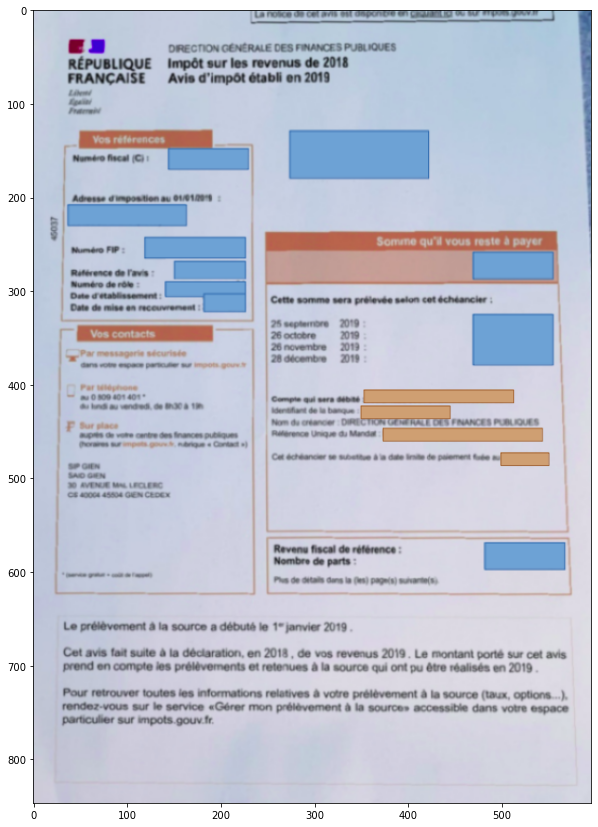

In [4]:
output_img = crop_image_SIFT('77.jpg', '17.jpg')
plt.figure(figsize = (10,15))
plt.imshow(output_img)

# 2 - Second model

The second model is composed of : 
- kmeans, an unsupervised - ML model for clustring.
- OpenCV packages for image processing and countours detection.
- Pytessreact to detect the letters's orientation.

Let's consider the following document : 

<img src="images/1__1_v2.png" style="margin:auto"/>

- To segment the document into many blocs, we used kmeans. Then, we get the main centroids and their colors : 

<img src="images/colors.JPG" style="margin:auto; width: 700px;"/>

- We filter on the color density of the cluster with the largest area located in the middle of the scan .

<img src="images/1__2_v2.png" style="margin:auto; width: 500px;"/>

- We apply delatation operator to remove noise from the scan. This opperation consists of convolving an image with a kernel which can have any shape or size, usually a square or circle. It grows the size of bright region in a image.

<img src="images/1__3_v2.png" style="margin:auto; width: 500px;"/>

- Then we detect the countour of the cluster with the largest area using OpenCV packages :  

<table><tr>
<td> <img src="images/1_4.JPG" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/fleche_1.png" alt="Drawing" style="width: 100px;"/> </td>      
    
<td> <img src="images/1__5_v2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

- We rotate the document based on the letters's orientation using pytesseract.

<table><tr>
<td> <img src="images/1__6_v2.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/fleche_1.png" alt="Drawing" style="width: 100px;"/> </td>     
    
<td> <img src="images/1__8_v2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

Finally, we zoom on the document after detecting the corners

<table><tr>
<td> <img src="images/1__8_last_v2.png" alt="Drawing" style="width: 500px;"/> </td>
<td> <img src="images/fleche_1.png" alt="Drawing" style="width: 100px;"/> </td>     
    
<td> <img src="images/corners_v2.png" alt="Drawing" style="width: 500px;"/> </td>
</tr></table>

## 3 - Implementation : 

In [4]:
def centroid_histogram(clt):
    """
    This function returns a color's histogram from centroid's position
    input :
        - clt : kmeans model after training
    """
    # grab the number of different clusters and create a histogram
    # based on the number of pixels assigned to each cluster
    numLabels = np.arange(0, len(np.unique(clt.labels_)) + 1)

    (hist, _) = np.histogram(clt.labels_, bins=numLabels)
    # normalize the histogram, such that it sums to one
    hist = hist.astype("float")
    hist /= hist.sum()
    # return the histogram
    return hist

In [5]:
def plot_colors(hist, centroids):
    """
    This function plots the colors's histogram
    input :
        - clt : kmeans model after training
        - centroids : centroids's
    """
    # initialize the bar chart representing the relative frequency
    # of each of the colors
    bar = np.zeros((50, 300, 3), dtype="uint8")
    startX = 0
    # loop over the percentage of each cluster and the color of
    # each cluster
    for (percent, color) in zip(hist, centroids):
        # plot the relative percentage of each cluster
        endX = startX + (percent * 300)
        cv2.rectangle(
            bar,
            (int(startX), 0),
            (int(endX), 50),
            color.astype("uint8").tolist(),
            -1,
        )
        startX = endX

    # return the bar chart
    return bar

In [6]:
def get_croners(bckgnd_masked, cntr_1, M, result_finale):
    """
    This function return the four corners of the document to
    zoom in it
    Input :
        - bckgnd_masked : mask of the image after rotation
        - cntr_1 : the external countour
        - M : Matrix of rotation
        - result_finale : input image
    """

    output_image = result_finale.copy()

    approx = cv2.approxPolyDP(
        cntr_1, 0.009 * cv2.arcLength(cntr_1, True), True
    )

    # draws boundary of contours.
    cv2.drawContours(bckgnd_masked, [approx], 0, (0, 0, 255), 5)

    # Used to flatted the array containing
    # the co-ordinates of the vertices.
    n = approx.ravel()
    i = 0
    points = []
    for j in n:
        if i % 2 == 0:
            x = n[i]
            y = n[i + 1]

            # String containing the co-ordinates.
            string = str(x) + " " + str(y)
            points.append([x, y])
        i = i + 1

    # rotate the points
    # using the rotation matrix
    points = np.array(points)

    # add ones
    ones = np.ones(shape=(len(points), 1))

    points_ones = np.hstack([points, ones])

    # transform points
    transformed_points = M.dot(points_ones.T).T

    # Get the x and y axis coordinates
    x_axis = transformed_points[:, 0].tolist()
    y_axis = transformed_points[:, 1].tolist()

    # In case we have 4 corners
    if len(x_axis) == 4:
        # In this part, we ge the coordinates of the lower point in
        # the upper half of the image and the highest point in the down
        # half of the image
        # Get the corner coordinates of the upper half of the image
        y_axis_array = np.array(y_axis)
        upper_index_y = np.where(
            y_axis_array > int(result_finale.shape[0] // 2)
        )[0].tolist()

        # Get the corner coordinates of the down half of the image
        down_index_y = [
            i for i in range(len(y_axis)) if i not in upper_index_y
        ]

        # Get the corner coordinates of the right half of the image
        x_axis_array = np.array(x_axis)
        upper_index_x = np.where(
            x_axis_array > int(result_finale.shape[1] // 2)
        )[0].tolist()

        # Get the corner coordinates of the left half of the image
        down_index_x = [
            i for i in range(len(x_axis)) if i not in upper_index_x
        ]

        # Get the y coordinate of the highest corner in the upper half of the image
        index_y1 = [y_axis[ele] for ele in upper_index_y].index(
            np.min([y_axis[ele] for ele in upper_index_y])
        )
        y1 = [y_axis[ele] for ele in upper_index_y][index_y1]

        # Get the y coordinate of the lowest corner in the upper half of the image
        index_y2 = [y_axis[ele] for ele in down_index_y].index(
            np.max([y_axis[ele] for ele in down_index_y])
        )
        y2 = [y_axis[ele] for ele in down_index_y][index_y2]

        # Get the x coordinate of the highest corner in the left half of the image
        index_x1 = [x_axis[ele] for ele in upper_index_x].index(
            np.min([x_axis[ele] for ele in upper_index_x])
        )
        x1 = [x_axis[ele] for ele in upper_index_x][index_x1]

        # Get the x coordinate of the highest corner in the right half of the image
        index_x2 = [x_axis[ele] for ele in down_index_x].index(
            np.max([x_axis[ele] for ele in down_index_x])
        )
        x2 = [x_axis[ele] for ele in down_index_x][index_x2]

        # Output image
        output_image = result_finale[
            int(np.min([y1, y2])) : int(np.max([y1, y2])),
            int(np.min([x1, x2])) : int(np.max([x1, x2])),
            :,
        ]

    return output_image

In [7]:
def cropp_image_kmeans(file_path):
    """
    This function cropp any document from any image

    inputs :
        - file_path : the input image's path
    output :
        - the extracted image of the document
    """

    # Read the image and transform it to HSV color space
    image = cv2.imread(file_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) / 255

    # plt.figure(figsize = (20,25))
    # plt.imshow(image)

    # reshape the image to be a list of pixels
    image_reshape = image.reshape((image.shape[0] * image.shape[1], 3))

    # cluster the pixel intensities using Kmeans
    clt = KMeans(n_clusters=4)
    cluster_labels = clt.fit_predict(image_reshape)

    # build a histogram of clusters and then create a figure
    # representing the number of pixels labeled to each color
    hist = centroid_histogram(clt)
    bar = plot_colors(hist, clt.cluster_centers_)

    # Get the lightest color
    list_colors = [
        np.sum(list_ele) for list_ele in clt.cluster_centers_.tolist()
    ]

    # normalize the list of colors to get the intensity
    list_colors_norm = list_colors / np.max(list_colors)

    # get the color's index with an intensity upper to 0.85
    index_colors = [
        i for i in range(len(list_colors_norm)) if list_colors_norm[i] > 0.85
    ]

    # get the cluster including their index in index_colors
    labels = clt.labels_
    labels = np.array(
        [1 if ele in index_colors else 0 for ele in labels.tolist()]
    )

    # create a mask from label vector
    mask = (labels.reshape(*gray.shape) * 255).astype(np.uint8)

    # plt.figure(figsize = (20,25))
    # plt.imshow(mask)

    # Taking a matrix of size 3 as the kernel
    kernel = np.ones((3, 3), np.uint8)

    # dilate the mask to smooth it
    img_dilation = cv2.dilate(mask, kernel, iterations=1)

    # get edges
    canny = cv2.Canny(img_dilation, 50, 200)

    # shapes
    hh, ww = canny.shape[:2]

    # plt.figure(figsize = (20,25))
    # plt.imshow(img_dilation)

    # get contours
    contours = cv2.findContours(
        img_dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )
    contours = contours[0] if len(contours) == 2 else contours[1]

    # Get the biggest countour and filter out small regions
    list_cntr_area, list_area = [], []
    for cntr in contours:
        area = cv2.contourArea(cntr)
        list_cntr_area.append((area, cntr))
        list_area.append(area)

    # filter out small regions
    cimg = np.zeros_like(canny)
    index_max_1 = list_area.index(np.max(list_area))
    cntr_1 = list_cntr_area[index_max_1][1]

    # draw countour
    cv2.drawContours(cimg, [cntr_1], 0, 255, 1)

    # plt.figure(figsize = (20,25))
    # plt.imshow(cimg)

    # get convex hull and draw on input
    points = np.column_stack(np.where(cimg.transpose() > 0))
    hull = cv2.convexHull(points)
    himg = image.copy()
    cv2.polylines(himg, [hull], True, (0, 0, 255), 1)

    # draw convex hull as filled mask
    mask = np.zeros_like(cimg, dtype=np.uint8)
    cv2.fillPoly(mask, [hull], 255)

    # blacken out input using mask
    mimg = image.copy()
    mimg = cv2.bitwise_and(mimg, mimg, mask=mask)

    # invert mask so shapes are white on black background
    mask_inv = 255 - mask

    # create new (white) background
    bckgnd = np.full_like(image, (255, 255, 255))

    # apply inverse mask to background
    bckgnd_masked = cv2.bitwise_and(bckgnd, bckgnd, mask=mask_inv)

    # add together
    result_intermedaire = cv2.add(mimg, bckgnd_masked)

    # plt.figure(figsize = (20,25))
    # plt.imshow(result_intermedaire)

    # get rotate rectangle
    rotrect = cv2.minAreaRect(hull)
    (center), (width, height), angle = rotrect
    box = cv2.boxPoints(rotrect)
    boxpts = np.int0(box)

    # draw rotated rectangle on copy of input
    rimg = result_intermedaire.copy()
    cv2.drawContours(rimg, [boxpts], 0, (0, 0, 255), 1)

    # the `cv2.minAreaRect` function returns values in the
    # range [-90, 0); as the rectangle rotates clockwise the
    # returned angle tends to 0 -- in this special case we
    # need to add 90 degrees to the angle
    if angle < -45:
        angle = -(90 + angle)

    # otherwise, check width vs height
    else:
        if width > height:
            angle = -(90 + angle)

        else:
            angle = -angle

    # negate the angle to unrotate
    neg_angle = -angle
    print("unrotation angle:", neg_angle)
    print("")

    # Get rotation matrix
    # center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, neg_angle, scale=1.0)

    # unrotate to rectify
    result = cv2.warpAffine(
        result_intermedaire,
        M,
        (ww, hh),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0),
    )

    # plt.figure(figsize = (20,25))
    # plt.imshow(result)

    # Rotated mask
    rotated_mask = cv2.warpAffine(
        mask,
        M,
        (ww, hh),
        flags=cv2.INTER_CUBIC,
        borderMode=cv2.BORDER_CONSTANT,
        borderValue=(0, 0, 0),
    )

    # invert mask so shapes are white on black background
    mask_inv_rotated = 255 - rotated_mask

    # create new (blue) background
    bckgnd = np.full_like(result, (255, 255, 255))

    # apply inverse mask to background
    bckgnd_masked = cv2.bitwise_and(bckgnd, bckgnd, mask=mask_inv_rotated)

    # add together
    result_finale = cv2.add(result, bckgnd_masked)

    # zoom in the document
    result_finale = get_croners(bckgnd_masked, cntr_1, M, result_finale)

    # get the coordinate of the image center
    a, b = int(result_finale.shape[0]) // 2, int(result_finale.shape[1]) // 2

    # save the image bloc
    cv2.imwrite(
        file_path.split(".")[0] + "____." + file_path.split(".")[1],
        result_finale[:a, :, :],
    )

    try:

        # Use pytesseract to get the letters's orientation
        rotate = pytesseract.image_to_osd(
            file_path.split(".")[0] + "____." + file_path.split(".")[1]
        )

        # rotate the document
        angle_rotation = re.search("(?<=Rotate: )\d+", rotate).group(0)
        print("angle de rotation ----- ", angle_rotation)
        result_finale = Image.fromarray(result_finale, "RGB").rotate(
            int(angle_rotation)
        )

    except:
        # exception in case pytesseract couldn't get the text orientation
        print("Pytesseract failed !")

    # Get the output
    text = str(pytesseract.image_to_string(result_finale, config="--psm 6"))

    return result_finale, text

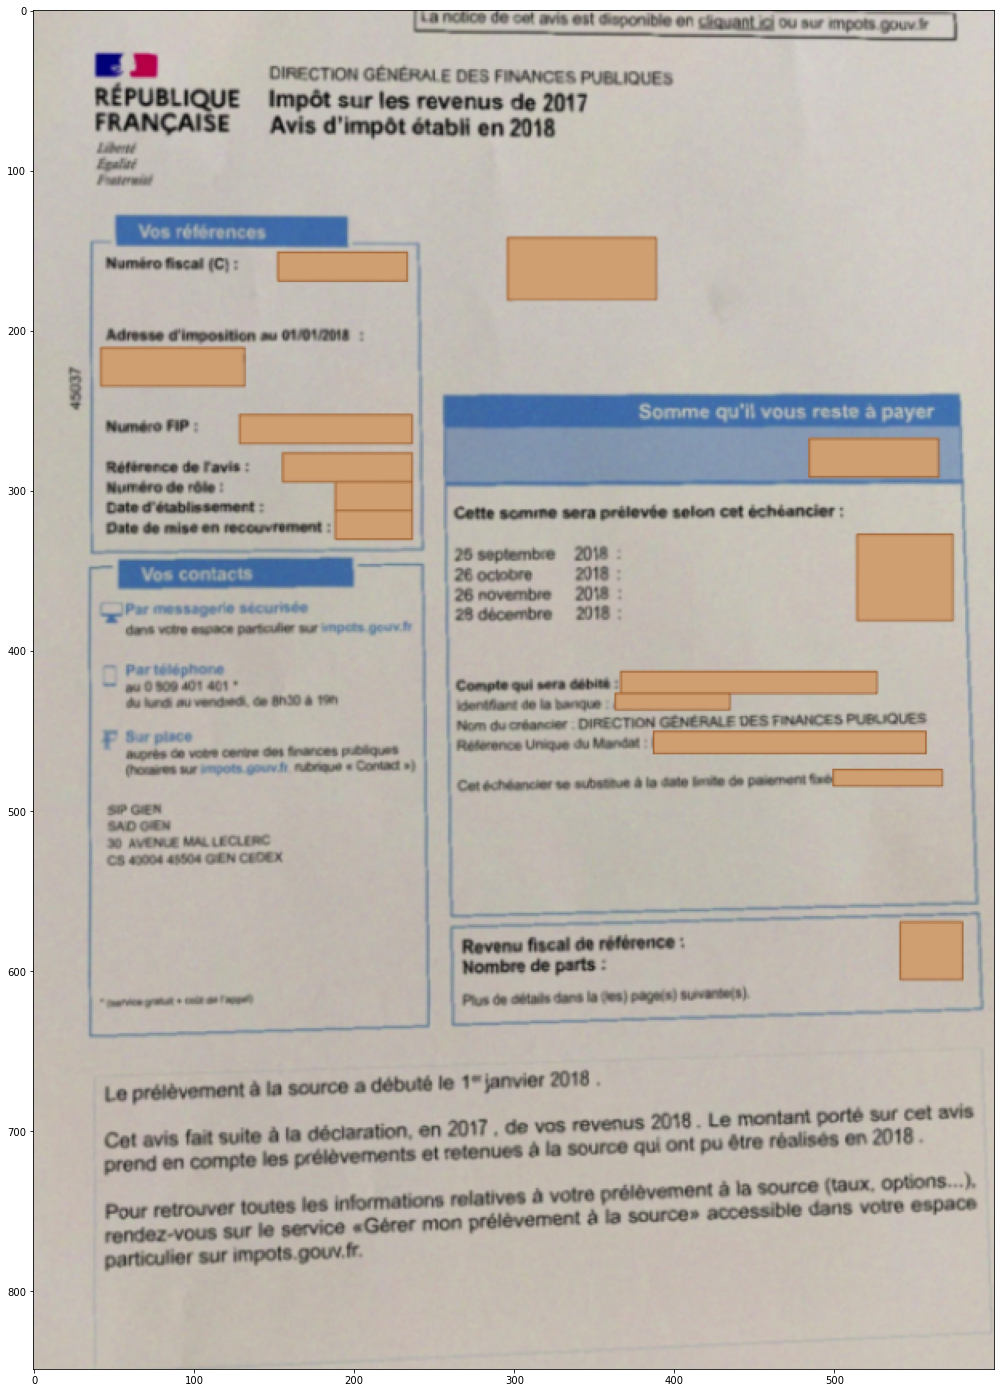

In [6]:
i = 14
file_path, filename_output = str(i) + ".jpg",  str(i) + "_temp_.jpg"
result_finale, text  = cropp_image_kmeans(file_path)
plt.figure(figsize = (10,15))
plt.imshow(result_finale)